In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Lectura del archivo
property_data = pd.read_csv('../../../sold_properties.csv')

### Nos quedamos con las propiedades de CABA y GBA

In [5]:
property_data = property_data[property_data.place_with_parent_names.str.contains('Capital Federal') | 
                            property_data.place_with_parent_names.str.contains('Bs.As. G.B.A.')]

##### Analisas de la informacion a procesar

In [59]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 27 columns):
id                            124746 non-null object
created_on                    124746 non-null object
operation                     124746 non-null object
property_type                 124746 non-null object
place_name                    124711 non-null object
place_with_parent_names       124746 non-null object
country_name                  124746 non-null object
state_name                    124746 non-null object
geonames_id                   97866 non-null float64
lat-lon                       75504 non-null object
lat                           75504 non-null float64
lon                           75504 non-null float64
price                         110203 non-null float64
currency                      110202 non-null object
price_aprox_local_currency    110203 non-null float64
price_aprox_usd               110203 non-null float64
surface_total_in_m2           89385 non

##### Solo nos importan algunas filas para lo que vamos a analizar
    Estas son:
        - place_name --> Para saber a que barrio corresponde
        - price_aprox_usd --> Para calcular el precio por m² en aquellas propiedades en que no se conozca
        - surface_total_in_m2 | surface_covered_in_m2 --> Idem anterior
        - price_usd_per_m2 --> Para analizar el valor del m²

In [9]:
init_data = property_data[['place_name', 'price_aprox_usd', 'surface_total_in_m2',\
                           'surface_covered_in_m2', 'price_usd_per_m2']]

##### Ahora vemos la consistencia de los datos de la tabla

In [10]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 5 columns):
place_name               124711 non-null object
price_aprox_usd          110203 non-null float64
surface_total_in_m2      89385 non-null float64
surface_covered_in_m2    109180 non-null float64
price_usd_per_m2         79108 non-null float64
dtypes: float64(4), object(1)
memory usage: 5.7+ MB


### Completamos las entradas que no tienen la información del valor del m² en caso que no esté. Siendo $price_{m^2} = \frac{price_{USD}}{surface_{total}}$

###### Primero definiremos una nueva columna 'surface_total', que será surface_covered_in_m2 si surface_total_in_m2 == NaN o surface_total_in_m2 en caso contrario 
        Hacemos un rename de las columnas para que sea mas facil escribir

In [28]:
init_data.columns = ['location', 'total_price', 'total_surface', 'covered_surface', 'm2_price']
init_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 5 columns):
location           124711 non-null object
total_price        110203 non-null float64
total_surface      89385 non-null float64
covered_surface    109180 non-null float64
m2_price           79108 non-null float64
dtypes: float64(4), object(1)
memory usage: 10.7+ MB


###### Mostramos algunas entradas del init_data para ver si la funcion está andando

In [33]:
init_data.head(5)

,location,total_price,total_surface,covered_surface,m2_price
0,San Antonio De Padua,120000.0,333.0,93.0,360.360360
1,San Antonio De Padua,220000.0,220.0,220.0,1000.000000
4,Mataderos,185000.0,300.0,103.0,616.666667
5,Pilar,97000.0,NaN,54.0,NaN
6,San Isidro,750000.0,NaN,NaN,NaN


###### Se define la funcion que completa los campos

In [34]:
def set_surface(row):
    total = row.total_surface
    covered = row.covered_surface
    if np.isnan(total):
        row.total_surface = covered
        return row
    return row

###### Aplicamos la funcion a todas las filas del DataFrame y vemos si modifico lo que antes vimos

In [32]:
surface_data = init_data.apply(set_surface, axis = 1)
surface_data.head(5)

,location,total_price,total_surface,covered_surface,m2_price
0,San Antonio De Padua,120000.0,333.0,93.0,360.360360
1,San Antonio De Padua,220000.0,220.0,220.0,1000.000000
4,Mataderos,185000.0,300.0,103.0,616.666667
5,Pilar,97000.0,54.0,54.0,NaN
6,San Isidro,750000.0,NaN,NaN,NaN


###### Hacemos un surface_data.info() para ver cuantas propiedades más podemos usar (es decir que tantas propiedades mas ahora tienen surface_total)
    Vemos que son casi 30mil propiedades

In [36]:
surface_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 5 columns):
location           124711 non-null object
total_price        110203 non-null float64
total_surface      115006 non-null float64
covered_surface    109180 non-null float64
m2_price           79108 non-null float64
dtypes: float64(4), object(1)
memory usage: 10.7+ MB


### Ahora procedemos a completar las columnas 'm2_price' en los casos posibles
    ~ Para esto, nos quedamos con las filas que cumplen la siguiente condicion lógica: (m2_price | (total_surface & total_price))
    ~ Además, eliminaremos covered_surface (que ya no nos sirve) y todas aquellas entradas que tengan valores iguales a 0 en los campos arriba mencionados 

###### Se elimina la columna covered_surface

In [40]:
filled_data = surface_data[['location', 'total_price', 'total_surface', 'm2_price']]
filled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 4 columns):
location         124711 non-null object
total_price      110203 non-null float64
total_surface    115006 non-null float64
m2_price         79108 non-null float64
dtypes: float64(3), object(1)
memory usage: 9.8+ MB


###### Se eliminan las entradas que no cumplen con las condiciones arriba mencionadas

In [52]:
useful_data = filled_data[(filled_data.m2_price > 0) | ((filled_data.total_price > 0) & (filled_data.total_surface > 0))]
useful_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103158 entries, 0 to 187480
Data columns (total 4 columns):
location         103124 non-null object
total_price      103158 non-null float64
total_surface    103158 non-null float64
m2_price         79107 non-null float64
dtypes: float64(3), object(1)
memory usage: 3.9+ MB


###### Se define la funcion que completa las columnas

In [54]:
def set_m2_price(row):
    price = row.total_price
    surface = row.total_surface
    if np.isnan(row.m2_price):
        row.m2_price = price/surface
        return row
    return row

###### Aplicamos la funcion a todas las filas del DataFrame y vemos como se mejoro

In [56]:
complete_data = useful_data.apply(set_m2_price, axis = 1)
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103158 entries, 0 to 187480
Data columns (total 4 columns):
location         103124 non-null object
total_price      103158 non-null float64
total_surface    103158 non-null float64
m2_price         103158 non-null float64
dtypes: float64(3), object(1)
memory usage: 3.9+ MB


###### Ahora queremos ver si los datos que nos metio la funcion estan bien

    Datos previos

In [57]:
useful_data.head(10)

,location,total_price,total_surface,m2_price
0,San Antonio De Padua,120000.0,333.0,360.360360
1,San Antonio De Padua,220000.0,220.0,1000.000000
4,Mataderos,185000.0,300.0,616.666667
5,Pilar,97000.0,54.0,NaN
10,Pilar,100000.0,45.0,NaN
12,Benavidez,390000.0,375.0,NaN
13,Florida,275000.0,111.0,NaN
29,Ramos Mejía,88000.0,60.0,1466.666667
31,Villa Luzuriaga,52000.0,37.0,1405.405405
32,San Isidro,550000.0,600.0,NaN


    Datos post-funcion

In [58]:
complete_data.head(10)

,location,total_price,total_surface,m2_price
0,San Antonio De Padua,120000.0,333.0,360.360360
1,San Antonio De Padua,220000.0,220.0,1000.000000
4,Mataderos,185000.0,300.0,616.666667
5,Pilar,97000.0,54.0,1796.296296
10,Pilar,100000.0,45.0,2222.222222
12,Benavidez,390000.0,375.0,1040.000000
13,Florida,275000.0,111.0,2477.477477
29,Ramos Mejía,88000.0,60.0,1466.666667
31,Villa Luzuriaga,52000.0,37.0,1405.405405
32,San Isidro,550000.0,600.0,916.666667


### Ahora que ya completamos todos los datos que podiamos completar, nos quedamos solo con los 103124 que tienen ubicacion

In [66]:
complete_data.dropna(inplace = True)
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103124 entries, 0 to 187480
Data columns (total 4 columns):
location         103124 non-null object
total_price      103124 non-null float64
total_surface    103124 non-null float64
m2_price         103124 non-null float64
dtypes: float64(3), object(1)
memory usage: 3.9+ MB


## Ahora que terminamos de limpiar los datos, vamos a analizar el precio por m²

#### Empezamos por quedarnos solo con 'location' y 'm2_price' (al que renombraremos 'price' para entenderlo mas facil)

In [75]:
price_m2 = complete_data[['location', 'm2_price']]
price_m2.columns = [['location', 'price']]
price_m2.head(5)

,location,price
0,San Antonio De Padua,360.360360
1,San Antonio De Padua,1000.000000
4,Mataderos,616.666667
5,Pilar,1796.296296
10,Pilar,2222.222222


#### Analizamos la distribucion del precio en general

In [76]:
price_m2.describe(percentiles = [0.01, 0.15, 0.25, 0.5, 0.75, 0.99])

,price
count,1.031240e+05
mean,2.701400e+03
std,1.660507e+04
min,6.275958e-02
1%,1.587643e+02
15%,8.750000e+02
25%,1.218434e+03
50%,1.857143e+03
75%,2.546090e+03
99%,1.787064e+04


    ~ Podemos ver que hay una propiedad (min) con precio 6 centavos y una (max) con precio 2.6 millones, mientras que la media esta en 2700 dolares.
    ~ Además, la diferencia entre el percentil .99 y el máximo es 2 ordenes de magnitud y la diferencia entre el minimo y el percentil .01 es de 4 ordenes de magnitud
    ~ Por esto, vamos a quedarnos solo con aquellas muestras que tengan un precio por metro cuadrado entre 150USD y 18000USD (1% y 99%) y lo volveremos a analizar

In [82]:
filtered_price = price_m2[(price_m2.price > 150) & (price_m2.price < 18000)]
filtered_price.describe(percentiles = [0.01, 0.15, 0.25, 0.5, 0.75, 0.95, 0.99])

,price
count,101123.000000
mean,2075.052286
std,1526.266972
min,150.341686
1%,240.000000
15%,900.000000
25%,1233.316667
50%,1857.142857
75%,2527.529367
95%,4250.000000


    ~ Ahora podemos ver que la distribucion es un poco mas normal pero que el percentil del 99% es menos de la mitad del valor máximo. Por esta razón, volveremos a cortar superiormente en el 99%.

In [86]:
filtered_price = filtered_price[filtered_price.price < 8000]
filtered_price.describe(percentiles = [0.01, 0.15, 0.25, 0.5, 0.75, 0.95, 0.99])

,price
count,100105.000000
mean,1974.579201
std,1123.206980
min,150.341686
1%,240.000000
15%,895.905588
25%,1225.000000
50%,1846.153846
75%,2500.000000
95%,3971.936961


    ~ Con este ultimo recorte vemos que la distribucion es bastante normal y sólo perdimos 3mil propiedades (menos del 3% del total) por lo que consideramos que los datos eliminiados no eran representativos

### Analisis general del precio por m2

#### Agrupamos todas las entradas por barrio

In [95]:
by_hood_raw = filtered_price.groupby('location').agg([np.mean, np.size])
by_hood_raw.head()

price       
                                mean   size
location                                   
 Country Maschwitz Club  1027.007249    4.0
 los alamos              1600.000000    1.0
9 de Abril                465.909091    2.0
Abasto                   2074.999669  123.0
Abril Club de Campo      1585.247548    6.0

##### Ahora necesitamos quedarnos solo con los barrios que tienen una cantidad representativa de propiedades vendidas. Para esto, hacemos un analisis de la informacion actual

In [96]:
by_hood_raw.describe()

price             
              mean         size
count   551.000000   551.000000
mean   1401.880646   181.678766
std     689.264572   485.480961
min     166.666667     1.000000
25%     968.340231     3.000000
50%    1309.994642    15.000000
75%    1714.210317   106.500000
max    5657.858638  4371.000000

    ~ Vemos que hay muchos barrios con menos de 50 propiedades vendidas, cosa que puede molestar en el analisis. Por lo tanto, nos vamos a quedar solo con aquellos barrios que tengan al menos 50 propiedades vendidas y volvemos a analizar. (Es aproximadamente una propiedad por mes en los ultimos 4 años)

In [99]:
by_hood = by_hood_raw[by_hood_raw[('price', 'size')] >= 50]
by_hood.describe()

price             
              mean         size
count   182.000000   182.000000
mean   1685.422458   528.736264
std     719.232886   731.470597
min     494.492459    50.000000
25%    1234.810796   109.250000
50%    1530.614031   261.500000
75%    2027.166476   623.500000
max    5657.858638  4371.000000

#### ¿Cuales son los 10 barrios mas caros?

In [109]:
top10 = by_hood[[('price', 'mean')]].sort_values(('price', 'mean'), ascending = False)[:10]
top10

,price
,mean
location,
Puerto Madero,5657.858638
Palermo Chico,4489.783862
Las Cañitas,3612.709961
Palermo Viejo,3419.251275
Recoleta,3316.277038
Palermo,3260.574617
Palermo Hollywood,3224.410918
Palermo Soho,3198.944997


###### Plot del top10

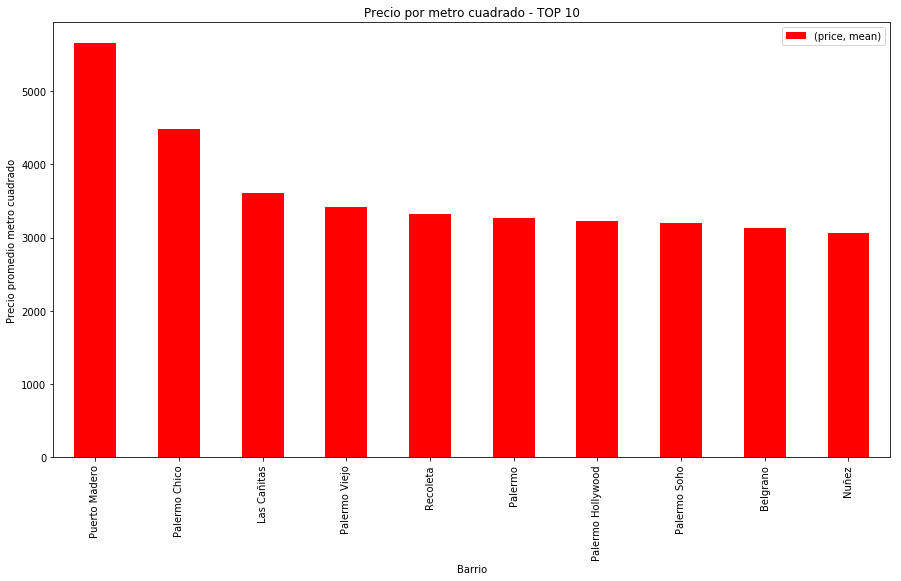

In [229]:
figure = plt.figure()

plt.title('Precio por metro cuadrado - TOP 10', color = 'black')

ax = top10.plot(kind = 'bar', stacked = True, figsize=(15, 8), ax = figure.gca(), color = 'r')
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles[::-1], labels[::-1], loc = 'upper right')

ax.set_ylabel('Precio promedio metro cuadrado')
ax.set_xlabel('Barrio')
plt.show()

#### Repetimos el analisis pero vamos a unificar todos los Palermos en uno solo

    ~ Definimos una función que unifica a todos los palermos

In [257]:
def join_palermos(row):
    if row.location.str.contains('Palermo').bool():
        row.location = 'Palermo'
        return row
    return row

    ~ Ahora se la aplicamos a todas las filas (necesitamos que location sea un elemento y no el indice)

In [242]:
hoods_indexed = by_hood[[('price', 'mean')]].reset_index()
hoods_indexed.head(3)

,location,price
,,mean
0,Abasto,2074.999669
1,Acassuso,2027.546447
2,Adrogué,1748.480784


    ~ Una vez que los tengo, necesito volver a hacer groupBy location

In [260]:
hoods_one_palermo = hoods_indexed.apply(join_palermos, axis = 1)
hoods = hoods_one_palermo.groupby('location').agg([np.mean])
hoods[105:110]

,price
,mean
,mean
location,
Olivos,2737.368578
Once,1952.103003
Palermo,3518.593134
Parque Avellaneda,1483.603986
Parque Centenario,2217.724739


In [264]:
hoods.columns = [['avg_price']]
hoods.head()

,avg_price
location,
Abasto,2074.999669
Acassuso,2027.546447
Adrogué,1748.480784
Agronomía,2062.602854
Almagro,2179.753288


#### Ahora volvemos a ordenarlos y tomar el top10

In [266]:
top10_op = hoods.sort_values('avg_price', ascending = False)[:10]
top10_op

,avg_price
location,
Puerto Madero,5657.858638
Las Cañitas,3612.709961
Palermo,3518.593134
Recoleta,3316.277038
Belgrano,3124.067558
Nuñez,3056.076175
Barrio Norte,2949.572636
Vicente López,2925.222557
Retiro,2783.694813


##### PLOT TOP10 SIN DIVISIONES

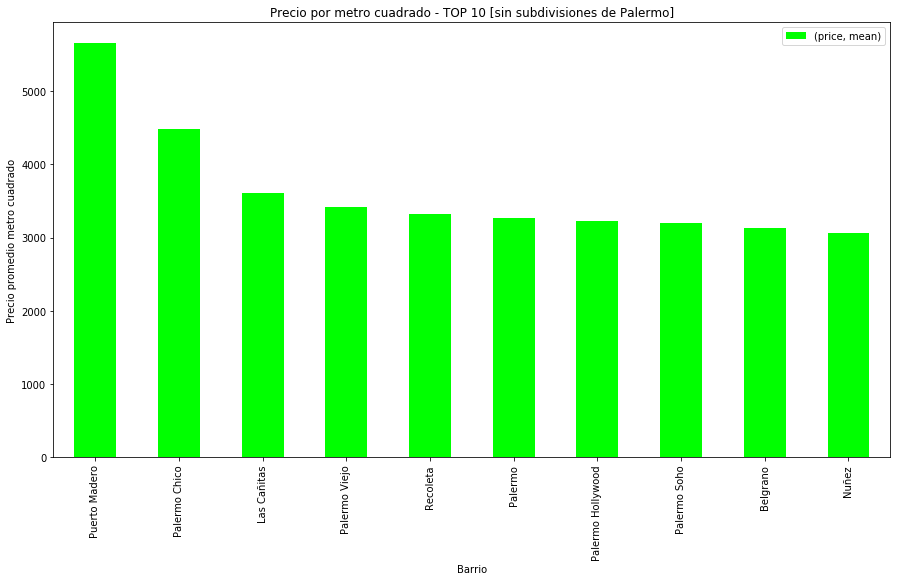

In [268]:
figure = plt.figure()

plt.title('Precio por metro cuadrado - TOP 10 [sin subdivisiones de Palermo]', color = 'black')

ax = top10.plot(kind = 'bar', stacked = True, figsize=(15, 8), ax = figure.gca(), color = 'lime')
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles[::-1], labels[::-1], loc = 'upper right')

ax.set_ylabel('Precio promedio metro cuadrado')
ax.set_xlabel('Barrio')
plt.show()